In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import cv2
from scipy import ndimage
import albumentations as A
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load a sample dataset - we'll use both a tabular dataset and an image dataset
# For tabular data, let's use the Titanic dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.head()

In [ ]:
# Basic Exploration
print(f"Dataset shape: {df.shape}")
print("\nMissing values per column:")
print(df.isnull().sum())

In [ ]:
# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Cabin'].fillna('Unknown', inplace=True)

# ----- FEATURE ENGINEERING FOR TABULAR DATA -----

In [ ]:
# 1. Extract title from name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Group rare titles
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [ ]:
# 2. Create family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1 for the passenger themselves

In [ ]:
# 3. Create is_alone feature
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [ ]:
# 4. Create fare per person
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

In [ ]:
# 5. Bin age into categories
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 65, 100], labels=['Child', 'Teenager', 'Adult', 'Elderly'])

In [ ]:
# 6. Bin fare into categories
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


In [ ]:
# 7. Create deck from cabin
df['Deck'] = df['Cabin'].str[0]
df['Deck'] = df['Deck'].replace(['T', 'A', 'G'], 'Other')
df['Deck'] = df['Deck'].replace('Unknown', 'U')


In [ ]:
# 8. Interaction features
df['Family_Survival'] = df['FamilySize'] * df['Survived']


In [ ]:
# 9. Categorical encodings
# One-hot encoding for categorical features
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin', 'Deck']
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

In [ ]:
# Combine with numerical features
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'FarePerPerson']
X = pd.concat([df[numerical_features], df_encoded], axis=1)
y = df['Survived']

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y)

In [ ]:
# Display top features
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(15)
print("\nTop 15 features:")
print(top_features)

In [ ]:
# Train a model with the engineered features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
print("\nModel accuracy with engineered features:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# ----- ADVANCED FEATURE ENGINEERING -----

In [ ]:
# 1. Polynomial features (example with a simple subset)
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Just using Age and Fare for demonstration
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_features.fit_transform(df[['Age', 'Fare']].fillna(0))

In [ ]:
# Display polynomial feature names
feature_names = poly_features.get_feature_names_out(['Age', 'Fare'])
print("\nPolynomial features generated:")
print(feature_names)

In [ ]:
# 2. PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Components')
plt.tight_layout()
plt.show()

In [ ]:
# Print cumulative explained variance
print("\nCumulative explained variance:")
print(np.cumsum(pca.explained_variance_ratio_))

# ----- DATA AUGMENTATION FOR IMAGES -----

In [ ]:
# Load MNIST dataset for image augmentation examples
(X_train_img, y_train_img), (X_test_img, y_test_img) = mnist.load_data()

In [ ]:
# Normalize the data
X_train_img = X_train_img / 255.0
X_test_img = X_test_img / 255.0

In [ ]:
# Expand dimensions for Keras (add channel dimension)
X_train_img = X_train_img.reshape(-1, 28, 28, 1)
X_test_img = X_test_img.reshape(-1, 28, 28, 1)

In [ ]:
# Display some original images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_img[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {y_train_img[i]}")
plt.tight_layout()
plt.show()


In [ ]:
# ----- 1. BASIC IMAGE AUGMENTATION WITH KERAS -----

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Visualize augmented images
augmented_images = []
for x_batch in datagen.flow(X_train_img[:5], batch_size=1, shuffle=False):
    augmented_images.append(x_batch[0])
    if len(augmented_images) >= 15:  # Generate 3 augmented versions of each of the 5 images
        break

In [ ]:
# Display augmented images
plt.figure(figsize=(12, 8))
for i, img in enumerate(augmented_images):
    plt.subplot(3, 5, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i < 5:
        plt.title(f"Original: {y_train_img[i]}")
plt.tight_layout()
plt.show()

In [ ]:
# ----- 2. AUGMENTATION WITH TF.IMAGE -----
def augment_with_tf(image):
    # Convert to float32
    image = tf.cast(image, tf.float32)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Ensure values are still between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [ ]:
# Apply tf.image augmentation to a few images
augmented_tf_images = []
for i in range(5):
    # Create 3 augmented versions of each image
    for _ in range(3):
        aug_img = augment_with_tf(X_train_img[i]).numpy()
        augmented_tf_images.append(aug_img)

In [ ]:
# Display tf.image augmented images
plt.figure(figsize=(12, 8))
for i, img in enumerate(augmented_tf_images):
    plt.subplot(3, 5, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('tf.image Augmentation')
plt.tight_layout()
plt.show()

In [ ]:
# ----- 3. AUGMENTATION WITH OPENCV -----

def opencv_augment(image):
    # Convert to 0-255 range and uint8 for OpenCV
    image = (image * 255).astype(np.uint8).reshape(28, 28)

    # Choose a random augmentation
    choice = np.random.choice(['rotate', 'blur', 'zoom', 'original'])

    if choice == 'rotate':
        # Random rotation
        angle = np.random.uniform(-15, 15)
        return ndimage.rotate(image, angle, reshape=False)

    elif choice == 'blur':
        # Add blur
        return cv2.GaussianBlur(image, (3, 3), 0)

    elif choice == 'zoom':
        # Random zoom
        zoom_factor = np.random.uniform(0.8, 1.2)
        height, width = image.shape

        # Compute new dimensions
        new_height = int(height * zoom_factor)
        new_width = int(width * zoom_factor)

        if zoom_factor < 1:  # Zoom out
            # Crop the image
            y_start = (height - new_height) // 2
            x_start = (width - new_width) // 2
            cropped = image[y_start:y_start+new_height, x_start:x_start+new_width]
            # Resize back to original size
            return cv2.resize(cropped, (width, height))
        else:  # Zoom in
            # Resize
            resized = cv2.resize(image, (new_width, new_height))
            # Crop to original size
            y_start = (new_height - height) // 2
            x_start = (new_width - width) // 2
            return resized[y_start:y_start+height, x_start:x_start+width]

    else:
        # Return original
        return image

In [ ]:

# Apply OpenCV augmentation
opencv_augmented = []
for i in range(5):
    # Create 3 augmented versions of each image
    for _ in range(3):
        aug_img = opencv_augment(X_train_img[i])
        # Normalize back to 0-1
        aug_img = aug_img.astype(np.float32) / 255.0
        opencv_augmented.append(aug_img)

# Display OpenCV augmented images
plt.figure(figsize=(12, 8))
for i, img in enumerate(opencv_augmented):
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('OpenCV Augmentation')
plt.tight_layout()
plt.show()

In [ ]:
# ----- 4. AUGMENTATION WITH ALBUMENTATIONS -----

def apply_albumentation(image):
    # Convert to 0-255 range and uint8 for Albumentations
    image = (image * 255).astype(np.uint8).reshape(28, 28)

    # Define transformation pipeline
    transform = A.Compose([
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
        ], p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
        ], p=0.5),
    ])

    # Apply transformation
    augmented = transform(image=image)['image']

    # Normalize back to 0-1
    return augmented.astype(np.float32) / 255.0

# Apply Albumentations
albu_augmented = []
for i in range(5):
    # Create 3 augmented versions of each image
    for _ in range(3):
        aug_img = apply_albumentation(X_train_img[i])
        albu_augmented.append(aug_img)

# Display Albumentations augmented images
plt.figure(figsize=(12, 8))
for i, img in enumerate(albu_augmented):
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Albumentations Augmentation')
plt.tight_layout()
plt.show()


In [ ]:
# ----- 5. TEXT DATA AUGMENTATION -----

# Sample texts
texts = [
    "This is a great product, I love it!",
    "The service was terrible and I'm disappointed.",
    "I'm not sure how I feel about this experience.",
    "The food was delicious and the staff was friendly.",
    "This movie is boring and too long."
]

In [ ]:
# Simple text augmentation techniques
def swap_words(text):
    words = text.split()
    if len(words) <= 1:
        return text

    idx1, idx2 = sorted(random.sample(range(len(words)), 2))
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def delete_random_word(text):
    words = text.split()
    if len(words) <= 1:
        return text

    idx = random.randrange(len(words))
    return ' '.join(words[:idx] + words[idx+1:])

def insert_random_word(text, word_list=["really", "very", "somewhat", "quite", "extremely"]):
    words = text.split()
    if not words:
        return text

    idx = random.randrange(len(words))
    word_to_insert = random.choice(word_list)
    return ' '.join(words[:idx] + [word_to_insert] + words[idx:])

In [ ]:
# Apply text augmentation
augmented_texts = []
for text in texts:
    augmented_texts.append(("Original", text))
    augmented_texts.append(("Word Swap", swap_words(text)))
    augmented_texts.append(("Word Deletion", delete_random_word(text)))
    augmented_texts.append(("Word Insertion", insert_random_word(text)))

In [ ]:
# Display original and augmented texts
print("\nText Data Augmentation Examples:")
for aug_type, text in augmented_texts:
    print(f"{aug_type}: {text}")

In [ ]:
# ----- 6. ADVANCED APPLICATION: AUGMENT TO BALANCE CLASSES -----

# Check distribution of classes in MNIST
unique, counts = np.unique(y_train_img, return_counts=True)
class_distribution = dict(zip(unique, counts))

plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('MNIST Training Set Class Distribution')
plt.show()

In [ ]:

def augment_minority_class(X, y, target_class, num_samples):
    # Find samples of the target class
    class_indices = np.where(y == target_class)[0]
    X_class = X[class_indices]

    # If we already have enough samples, no need to augment
    if len(X_class) >= num_samples:
        return X, y

    # Number of augmentations needed
    num_augmentations = num_samples - len(X_class)

    # Create augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images
    augmented_images = []
    augmented_labels = []

    for x_batch in datagen.flow(X_class, batch_size=1, shuffle=True):
        augmented_images.append(x_batch[0])
        augmented_labels.append(target_class)
        if len(augmented_images) >= num_augmentations:
            break

    # Convert to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Combine original and augmented data
    X_balanced = np.vstack([X, augmented_images])
    y_balanced = np.hstack([y, augmented_labels])

    return X_balanced, y_balanced

In [ ]:
# Demonstrate balancing a subset of MNIST
# For demonstration, let's use just 100 samples per class initially
X_sample = []
y_sample = []

for digit in range(10):
    indices = np.where(y_train_img == digit)[0][:100]  # Take 100 samples of each digit
    X_sample.extend(X_train_img[indices])
    y_sample.extend(y_train_img[indices])

X_sample = np.array(X_sample)
y_sample = np.array(y_sample)

In [ ]:
# Print initial distribution
unique, counts = np.unique(y_sample, return_counts=True)
print("\nInitial distribution:")
print(dict(zip(unique, counts)))

In [ ]:
# Let's artificially create an imbalance by removing some '8' samples
eight_indices = np.where(y_sample == 8)[0]
remove_indices = eight_indices[:80]  # Remove 80 samples of digit 8
mask = np.ones(len(y_sample), dtype=bool)
mask[remove_indices] = False

X_imbalanced = X_sample[mask]
y_imbalanced = y_sample[mask]


In [ ]:
# Print imbalanced distribution
unique, counts = np.unique(y_imbalanced, return_counts=True)
print("\nImbalanced distribution:")
print(dict(zip(unique, counts)))


In [ ]:
# Balance the dataset using augmentation
X_balanced, y_balanced = augment_minority_class(X_imbalanced, y_imbalanced, 8, 100)

# Print balanced distribution
unique, counts = np.unique(y_balanced, return_counts=True)
print("\nBalanced distribution after augmentation:")
print(dict(zip(unique, counts)))

In [ ]:
# ----- 7. DEMONSTRATING THE EFFECT OF AUGMENTATION ON MODEL PERFORMANCE -----

# Create a simple CNN model for MNIST
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Train model on imbalanced data
model_imbalanced = create_model()
history_imbalanced = model_imbalanced.fit(X_imbalanced, y_imbalanced, epochs=5,
                                           validation_split=0.2, verbose=0)


In [ ]:
# Train model on balanced data
model_balanced = create_model()
history_balanced = model_balanced.fit(X_balanced, y_balanced, epochs=5,
                                       validation_split=0.2, verbose=0)

In [ ]:
# Compare performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_imbalanced.history['accuracy'], label='Imbalanced - Train')
plt.plot(history_imbalanced.history['val_accuracy'], label='Imbalanced - Validation')
plt.plot(history_balanced.history['accuracy'], label='Balanced - Train')
plt.plot(history_balanced.history['val_accuracy'], label='Balanced - Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_imbalanced.history['loss'], label='Imbalanced - Train')
plt.plot(history_imbalanced.history['val_loss'], label='Imbalanced - Validation')
plt.plot(history_balanced.history['loss'], label='Balanced - Train')
plt.plot(history_balanced.history['val_loss'], label='Balanced - Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Excercise

In [1]:
# 1. Setup and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TODO: Load the Titanic dataset into `df` using pd.read_csv
# Hint: URL = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')  # TODO

# TODO: Display first 5 rows and the dataset shape
print("First 5 rows:")
print(df.head())
print("\nDataset shape:", df.shape)

# TODO: Print missing value counts per column
print("\nMissing value counts per column:")
print(df.isnull().sum())

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN

In [2]:
# TODO: Fill missing 'Age' with its median
df['Age'] = df['Age'].fillna(df['Age'].median())

# TODO: Fill missing 'Embarked' with its mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# TODO: Replace missing 'Cabin' entries with 'Unknown'
df['Cabin'] = df['Cabin'].fillna('Unknown')

# Verify the changes
print("\nMissing value counts after imputation:")
print(df.isnull().sum())


Missing value counts after imputation:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [3]:
# 3.1 Extract Title from Name
# TODO: Create df['Title'] by extracting the substring before '.' in Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 3.2 Group rare titles into 'Rare' and standardize variants
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
# Replace rare and variant titles
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# 3.3 Family Size and IsAlone
# TODO: df['FamilySize'] = SibSp + Parch + 1
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# TODO: df['IsAlone'] = 1 where FamilySize == 1, else 0
df['IsAlone'] = np.where(df['FamilySize'] == 1, 1, 0)

# 3.4 Fare Per Person
# TODO: df['FarePerPerson'] = Fare / FamilySize
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# 3.5 Age and Fare Binning
# TODO: Create AgeBin categories: Child (0-12), Teenager (13-18), Adult (19-65), Elderly (>65)
bins = [0, 12, 18, 65, np.inf]
labels = ['Child', 'Teenager', 'Adult', 'Elderly']
df['AgeBin'] = pd.cut(df['Age'], bins=bins, labels=labels)

# TODO: Create FareBin quantiles: Low, Medium, High, Very High
df['FareBin'] = pd.qcut(df['FarePerPerson'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 3.6 Deck from Cabin
# TODO: df['Deck'] = first letter of Cabin; replace 'Unknown'→'U' and rare letters→'Other'
df['Deck'] = df['Cabin'].str[0].fillna('U')
# Replace rare decks with 'Other'
rare_decks = ['T', 'G']
df['Deck'] = df['Deck'].replace(rare_decks, 'Other')

# Verify the new features
print("\nNew features created:")
print(df[['Title', 'FamilySize', 'IsAlone', 'FarePerPerson', 'AgeBin', 'FareBin', 'Deck']].head())


New features created:
  Title  FamilySize  IsAlone  FarePerPerson AgeBin    FareBin Deck
0    Mr           2        0        3.62500  Adult        Low    U
1   Mrs           2        0       35.64165  Adult  Very High    C
2  Miss           1        1        7.92500  Adult     Medium    U
3   Mrs           2        0       26.55000  Adult  Very High    C
4    Mr           1        1        8.05000  Adult     Medium    U


In [4]:
# 4. Encoding and Scaling

# 4.1 One-hot encode selected categorical columns using pd.get_dummies
categorical = ['Pclass','Sex','Embarked','Title','AgeBin','FareBin','Deck']
# TODO: df_encoded = pd.get_dummies(df[categorical], drop_first=True)
df_encoded = pd.get_dummies(df[categorical], drop_first=True)

# 4.2 Combine with numerical features
numerical = ['Age','SibSp','Parch','Fare','FamilySize','IsAlone','FarePerPerson']
# TODO: X = pd.concat([...], axis=1)
X = pd.concat([df[numerical], df_encoded], axis=1)
# TODO: y = df['Survived']
y = df['Survived']

# 4.3 Feature scaling: fit three different scalers and transform X
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# TODO: scaler_std = StandardScaler()
scaler_std = StandardScaler()
# TODO: scaler_mm = MinMaxScaler()
scaler_mm = MinMaxScaler()
# TODO: scaler_rbv = RobustScaler()
scaler_rbv = RobustScaler()
# TODO: X_std = scaler_std.fit_transform(X)
X_std = scaler_std.fit_transform(X)
# TODO: X_mm = scaler_mm.fit_transform(X)
X_mm = scaler_mm.fit_transform(X)
# TODO: X_rb = scaler_rbv.fit_transform(X)
X_rb = scaler_rbv.fit_transform(X)

# Print shapes to verify
print("\nFeature matrix shapes:")
print(f"Original X: {X.shape}")
print(f"StandardScaler X: {X_std.shape}")
print(f"MinMaxScaler X: {X_mm.shape}")
print(f"RobustScaler X: {X_rb.shape}")


Feature matrix shapes:
Original X: (891, 28)
StandardScaler X: (891, 28)
MinMaxScaler X: (891, 28)
RobustScaler X: (891, 28)


In [5]:
# 5. Feature Selection & Modeling

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Feature Selection
# TODO: Use SelectKBest(f_classif, k=15) to pick top features
selector = SelectKBest(f_classif, k=15)  # TODO
# TODO: X_sel = selector.fit_transform(X_std, y)
X_sel = selector.fit_transform(X_std, y)
# TODO: top_feats = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_}).nlargest(15,'Score')
top_feats = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_}).nlargest(15, 'Score')

print("Top 15 features:")
print(top_feats)

# Modeling
# TODO: Split into train/test (25% test), train RandomForestClassifier, and print:
#       - Accuracy
#       - Classification report
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.25, random_state=42)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Top 15 features:
              Feature       Score
12           Title_Mr  383.945495
8            Sex_male  372.405724
13          Title_Mrs  117.749079
7              Pclass  115.031272
11         Title_Miss  112.860827
27             Deck_U   99.253142
20  FareBin_Very High   67.501056
3                Fare   63.030764
6       FarePerPerson   45.910184
5             IsAlone   38.353651
21             Deck_B   28.117228
18     FareBin_Medium   21.090717
23             Deck_D   20.663186
10         Embarked_S   20.374460
24             Deck_E   19.179221

Model Evaluation:
Accuracy: 0.8072

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       134
           1       0.74      0.80      0.77        89

    accuracy                           0.81       223
   macro avg       0.80      0.81      0.80       223
weighted avg       0.81      0.81      0.81       223



Polynomial feature names:
['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']


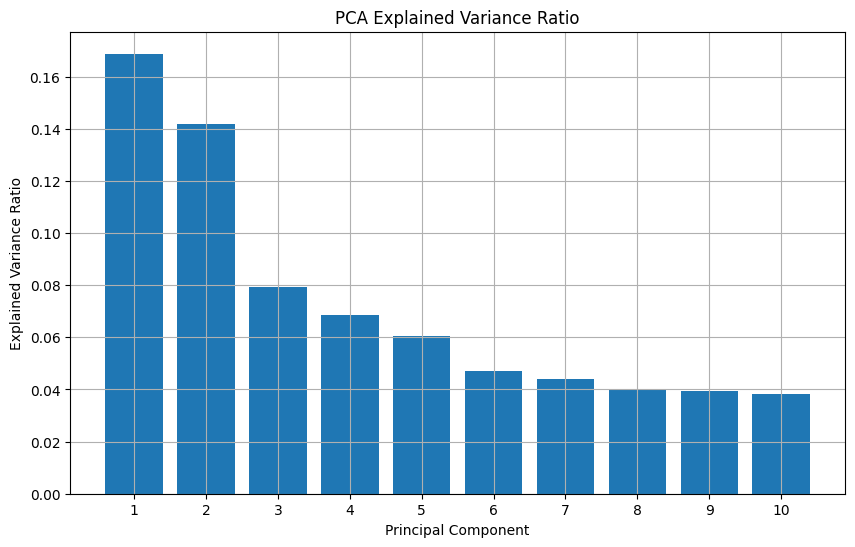


Cumulative Explained Variance:
[0.16875333 0.31041444 0.38968515 0.45810486 0.51841604 0.56532828
 0.60947196 0.64967553 0.68890375 0.72700003]


In [6]:
# 6. Advanced Feature Engineering

# 6.1 Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
# TODO: poly = PolynomialFeatures(degree=2, include_bias=False)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# TODO: poly_data = poly.fit_transform(df[['Age','Fare']].fillna(0))
poly_data = poly.fit_transform(df[['Age','Fare']].fillna(0))
# TODO: print(poly.get_feature_names_out(['Age','Fare']))
print("Polynomial feature names:")
print(poly.get_feature_names_out(['Age','Fare']))

# 6.2 PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# TODO: pca = PCA(n_components=10)
pca = PCA(n_components=10)
# TODO: X_pca = pca.fit_transform(X_std)
X_pca = pca.fit_transform(X_std)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Print cumulative variance
print("\nCumulative Explained Variance:")
print(np.cumsum(pca.explained_variance_ratio_))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


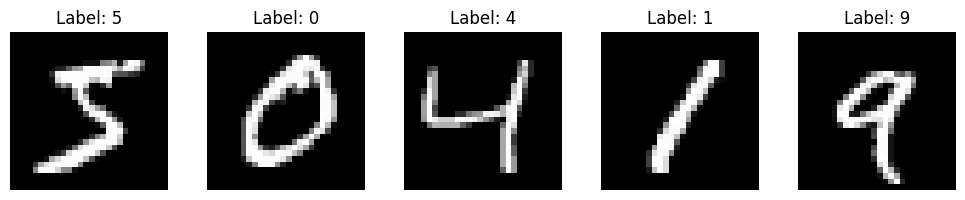

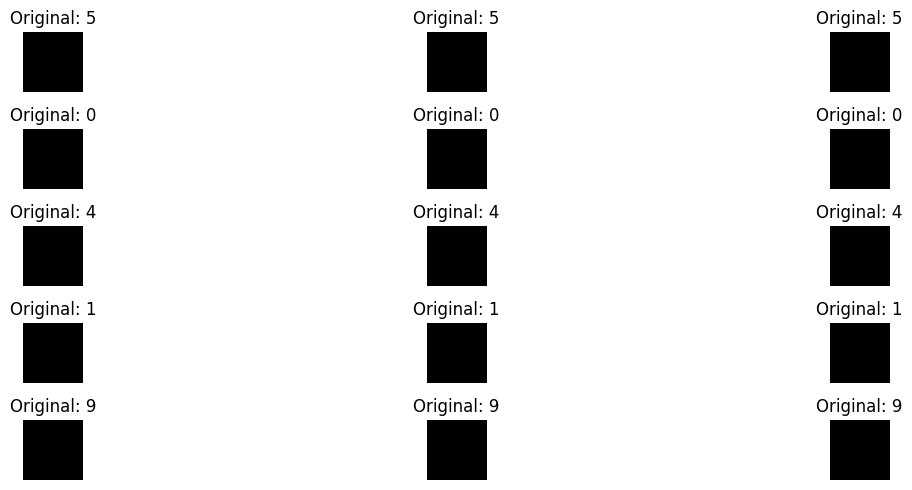

NameError: name 'A' is not defined

In [7]:
# 7. Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# TODO: Load MNIST, normalize, and reshape to (28,28,1)
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

# TODO: Display 5 sample images with true labels
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 7.1 Keras ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            shear_range=0.1,
                            brightness_range=[0.5,1.5],
                            horizontal_flip=True,
                            fill_mode='nearest')

# TODO: Generate and plot 3 augmentations per sample for first 5 images
plt.figure(figsize=(15, 5))
for i in range(5):
    img = x_train[i]
    for j in range(3):
        plt.subplot(5, 3, i*3 + j + 1)
        augmented = datagen.random_transform(img)
        plt.imshow(augmented.squeeze(), cmap='gray')
        plt.title(f"Original: {y_train[i]}")
        plt.axis('off')
plt.tight_layout()
plt.show()

# 7.2 tf.image augmentations
def tf_augment(image):
    # Random 90 degree rotations
    image = tf.image.rot90(image, k=np.random.randint(0, 4))
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image

# 7.3 OpenCV augmentations
def opencv_augment(image):
    image = image.squeeze()
    choice = np.random.choice(['rotate', 'blur', 'zoom'])

    if choice == 'rotate':
        angle = np.random.uniform(-15, 15)
        image = ndimage.rotate(image, angle, reshape=False)
    elif choice == 'blur':
        ksize = np.random.choice([3, 5])
        image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    else:  # zoom
        scale = np.random.uniform(0.8, 1.2)
        h, w = image.shape
        cx, cy = w//2, h//2
        M = cv2.getRotationMatrix2D((cx, cy), 0, scale)
        image = cv2.warpAffine(image, M, (w, h))

    return np.expand_dims(image, axis=-1)

# 7.4 Albumentations pipeline
albumentations_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.3),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3)
])

# Example usage of Albumentations
def apply_albumentations(image):
    augmented = albumentations_transform(image=image.squeeze())
    return np.expand_dims(augmented['image'], axis=-1)

In [8]:
# 8. Text Data Augmentation

import random
from random import shuffle

# Sample sentences
texts = [
    "The quick brown fox jumps over the lazy dog",
    "Natural language processing enables computers to understand human language",
    "Data augmentation creates additional training samples",
    "Machine learning models improve with more diverse data",
    "Text preprocessing is an essential step in NLP pipelines"
]

# Augmentation functions
def swap_words(text):
    words = text.split()
    if len(words) > 1:
        # Get two random positions to swap
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def delete_random_word(text):
    words = text.split()
    if len(words) > 1:
        del words[random.randint(0, len(words)-1)]
    return ' '.join(words)

def insert_random_word(text):
    words = text.split()
    # Simple word bank for insertion - could be expanded
    word_bank = ['new', 'additional', 'random', 'artificial', 'sample']
    insert_pos = random.randint(0, len(words))
    words.insert(insert_pos, random.choice(word_bank))
    return ' '.join(words)

# Apply and display augmentations
for text in texts:
    print(f"\nOriginal: {text}")
    print(f"Swap:     {swap_words(text)}")
    print(f"Delete:   {delete_random_word(text)}")
    print(f"Insert:   {insert_random_word(text)}")
    print("-" * 60)


Original: The quick brown fox jumps over the lazy dog
Swap:     The lazy brown fox jumps over the quick dog
Delete:   The quick fox jumps over the lazy dog
Insert:   The artificial quick brown fox jumps over the lazy dog
------------------------------------------------------------

Original: Natural language processing enables computers to understand human language
Swap:     processing language Natural enables computers to understand human language
Delete:   Natural language processing computers to understand human language
Insert:   Natural language processing enables new computers to understand human language
------------------------------------------------------------

Original: Data augmentation creates additional training samples
Swap:     Data augmentation samples additional training creates
Delete:   Data augmentation creates additional training
Insert:   Data augmentation creates additional training artificial samples
-----------------------------------------------------------

Original class distribution:
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples
Generating 819 augmented samples for class 0
Class 1 already has sufficient samples (6742)
Generating 784 augmented samples for class 2
Generating 611 augmented samples for class 3
Generating 900 augmented samples for class 4
Generating 1321 augmented samples for class 5
Generating 824 augmented samples for class 6
Generating 477 augmented samples for class 7
Generating 891 augmented samples for class 8
Generating 793 augmented samples for class 9

Balanced class distribution:
Class 0: 6742 samples
Class 1: 6742 samples
Class 2: 6742 samples
Class 3: 6742 samples
Class 4: 6742 samples
Class 5: 6742 samples
Class 6: 6742 samples
Class 7: 6742 samples
Class 8: 6742 samples
Class 9: 6742 samples


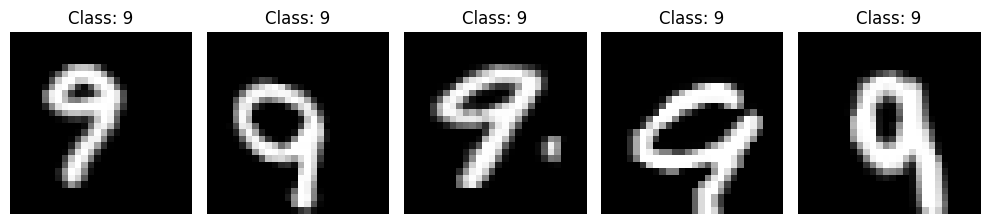

In [10]:
# 9. Class Balancing via Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load sample image data (MNIST)
(X_train_img, y_train_img), (_, _) = mnist.load_data()
X_train_img = np.expand_dims(X_train_img, axis=-1)  # Add channel dimension
X_train_img = X_train_img.astype('float32') / 255.0  # Normalize

# TODO: Compute class distribution of y_train_img
class_counts = np.bincount(y_train_img)
print("Original class distribution:")
for class_idx, count in enumerate(class_counts):
    print(f"Class {class_idx}: {count} samples")

def augment_minority_class(X, y, target_class, target_count):
    """
    Balances a minority class through augmentation.

    Args:
        X: Input images (num_samples, height, width, channels)
        y: Labels (num_samples,)
        target_class: The minority class to augment
        target_count: Desired number of samples for this class

    Returns:
        X_balanced: Augmented dataset with balanced classes
        y_balanced: Corresponding labels
    """
    # Get indices of target class samples
    class_indices = np.where(y == target_class)[0]
    current_count = len(class_indices)

    if current_count >= target_count:
        print(f"Class {target_class} already has sufficient samples ({current_count})")
        return X, y

    # Calculate needed samples
    needed = target_count - current_count
    print(f"Generating {needed} augmented samples for class {target_class}")

    # Setup augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

    # Generate augmented samples
    augmented_samples = []
    for batch in datagen.flow(X[class_indices], batch_size=min(32, current_count), shuffle=False):
        augmented_samples.append(batch)
        if len(augmented_samples) * batch.shape[0] >= needed:
            break

    augmented_samples = np.concatenate(augmented_samples)[:needed]
    augmented_labels = np.full(needed, target_class)

    # Combine with original data
    X_balanced = np.concatenate([X, augmented_samples])
    y_balanced = np.concatenate([y, augmented_labels])

    return X_balanced, y_balanced

# Balance classes to match majority count
majority_count = max(class_counts)
X_balanced, y_balanced = X_train_img, y_train_img

for class_idx in np.unique(y_train_img):
    X_balanced, y_balanced = augment_minority_class(
        X_balanced, y_balanced,
        target_class=class_idx,
        target_count=majority_count
    )

# Verify new distribution
balanced_counts = np.bincount(y_balanced)
print("\nBalanced class distribution:")
for class_idx, count in enumerate(balanced_counts):
    print(f"Class {class_idx}: {count} samples")

# Visualize some augmented samples
plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_balanced[-5+i].squeeze(), cmap='gray')  # Show some augmented samples
    plt.title(f"Class: {y_balanced[-5+i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Training on imbalanced data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


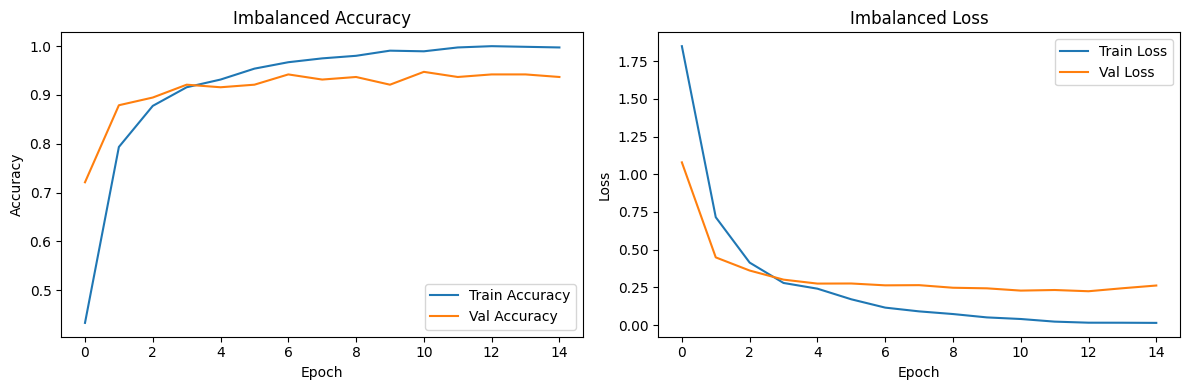

Training on balanced data...


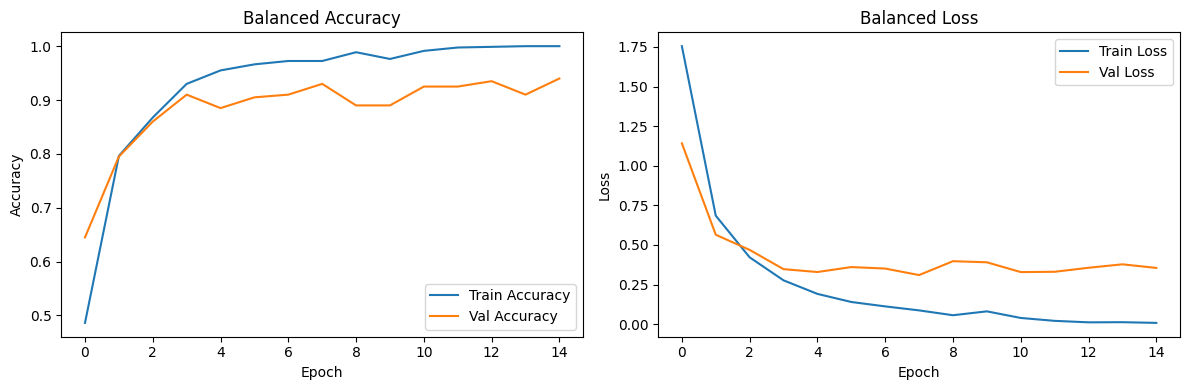


Final Validation Accuracy:
Imbalanced: 0.9368
Balanced: 0.9400


In [11]:
# 10. Effect of Augmentation on Model Performance

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Prepare imbalanced dataset (MNIST example)
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train_full = np.expand_dims(X_train_full, axis=-1).astype('float32') / 255.0

# Create imbalanced dataset (100 samples per class, but only 50 for class 8)
imbalanced_indices = []
for class_idx in range(10):
    class_indices = np.where(y_train_full == class_idx)[0]
    samples = 50 if class_idx == 8 else 100  # Make class 8 underrepresented
    imbalanced_indices.extend(class_indices[:samples])

X_train_imbalanced = X_train_full[imbalanced_indices]
y_train_imbalanced = y_train_full[imbalanced_indices]

# 2. Balance the dataset using augmentation
def balance_via_augmentation(X, y):
    class_counts = np.bincount(y)
    majority_count = max(class_counts)

    X_balanced, y_balanced = X.copy(), y.copy()

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest'
    )

    for class_idx in range(10):
        if class_counts[class_idx] < majority_count:
            needed = majority_count - class_counts[class_idx]
            class_indices = np.where(y == class_idx)[0]

            # Generate augmented samples
            augmented = []
            for batch in datagen.flow(X[class_indices], batch_size=len(class_indices), shuffle=False):
                augmented.append(batch)
                if len(augmented) * len(class_indices) >= needed:
                    break

            augmented = np.concatenate(augmented)[:needed]
            X_balanced = np.concatenate([X_balanced, augmented])
            y_balanced = np.concatenate([y_balanced, np.full(needed, class_idx)])

    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = balance_via_augmentation(X_train_imbalanced, y_train_imbalanced)

# 3. Define CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# 4. Train and evaluate models
def train_and_evaluate(X_train, y_train, title):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = create_model()
    history = model.fit(X_train, y_train,
                       epochs=15,
                       batch_size=32,
                       validation_data=(X_val, y_val),
                       verbose=0)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

# Train on imbalanced data
print("Training on imbalanced data...")
imbalanced_history = train_and_evaluate(X_train_imbalanced, y_train_imbalanced, "Imbalanced")

# Train on balanced data
print("Training on balanced data...")
balanced_history = train_and_evaluate(X_train_balanced, y_train_balanced, "Balanced")

# Compare final performance
print("\nFinal Validation Accuracy:")
print(f"Imbalanced: {imbalanced_history.history['val_accuracy'][-1]:.4f}")
print(f"Balanced: {balanced_history.history['val_accuracy'][-1]:.4f}")

**Experiment: feel free to tweak parameters (e.g., k in SelectKBest, PCA components, augmentation ranges) to see their impact.**